# About

* In this notebook features are generated and added to train, val and test candidates.
* Data is prepared and saved for training and inference.
    * Folds file is created.
    * Train set is downsampled. Test and val set are split into multiple files.

# Import 

In [1]:
VER = 1

In [2]:
import xgboost as xgb
import datetime
import cudf
import glob
import sys
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import psutil
import numpy as np
import gc
import time
import random
from time import sleep

# Config

In [3]:
class cfg:
    local         = False
    
    track_gpu_mem = True
    seed          = 101
    val_fold      = 0 # val fold convinient to set here
    
    downsample_neg_rep = 0.25

    add_features = {
        'add_events_in_prev_hours': True,
        
        'add_session_ts_info': True,
        'add_session_num_events': False,

        'add_session_length': True,
        'add_session_type_mean': True,

        'add_aid_all_num_log': True,
        'add_aids_in_day': [1,2],
    }

In [4]:
# Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY
def set_seed(seed = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    cudf.cupy.random.seed(seed)

    print('Setting seed done')
    
set_seed(cfg.seed)

Setting seed done


In [5]:
# # Last week of train set is used for training here

if cfg.local:
    train_files = glob.glob('../../../downloaded_data/split_data_local_validation/test_parquet/*')
    train_labels_path = '../../../downloaded_data/split_data_local_validation/test_labels.parquet'
    
    test_files = glob.glob('../../../downloaded_data/split_data/test_parquet/*')
else:
    train_files = glob.glob('/kaggle/input/otto-validation/test_parquet/*')
    train_labels_path = '/kaggle/input/otto-validation/test_labels.parquet'

    test_files = glob.glob('/kaggle/input/otto-chunk-data-inparquet-format/test_parquet/*')

In [6]:
pred_df_files = {}
test_pred_df_files = {}
if cfg.local:
    pred_df_files['clicks'] = glob.glob('data/pred_df_clicks_*')
    pred_df_files['carts'] = glob.glob('data/pred_df_carts_*')
    pred_df_files['orders'] = glob.glob('data/pred_df_orders_*')

    test_pred_df_files['clicks'] = glob.glob('data/test_pred_df_clicks*')
    test_pred_df_files['carts'] = glob.glob('data/test_pred_df_carts*')
    test_pred_df_files['orders'] = glob.glob('data/test_pred_df_orders*')
else:
    pred_df_files['clicks'] = glob.glob('/kaggle/input/covisitation-to-canidates-dataset/pred_df_clicks_*')
    pred_df_files['carts'] = glob.glob('/kaggle/input/covisitation-to-canidates-dataset/pred_df_carts_*')
    pred_df_files['orders'] = glob.glob('/kaggle/input/covisitation-to-canidates-dataset/pred_df_orders_*')

    test_pred_df_files['clicks'] = glob.glob('/kaggle/input/covisitation-to-test-candidates-dataset/pred_df_clicks*')
    test_pred_df_files['carts'] = glob.glob('/kaggle/input/covisitation-to-test-candidates-dataset/pred_df_carts*')
    test_pred_df_files['orders'] = glob.glob('/kaggle/input/covisitation-to-test-candidates-dataset/pred_df_orders*')

print('Train files:')
for k,v in pred_df_files.items():
    print(k, len(v))

print('Test files:')
for k,v in test_pred_df_files.items():
    print(k, len(v))

Train files:
clicks 10
carts 10
orders 10
Test files:
clicks 10
carts 10
orders 10


# Helper functions

In [7]:
def ts_format(ts):
    return datetime.datetime.fromtimestamp(ts).strftime("%b %d %Y  %H:%M:%S")
def print_date_ts(ts, end='\n'):
    print(ts_format(ts), end=end)
def print_date(d, end='\n'):
    print(d.strftime("%b %d %Y  %H:%M:%S"), end=end)
def mils_format(x):
    return f'{x:,}'
def len_mils(x):
    return mils_format(len(x))

In [8]:
def display_before_save(df):
    print(len_mils(df))
    print(df.dtypes)
    display(df.head())

In [9]:
def candidates_overlapping_with_type_overlap(candidates_df, labels_df):
    l = []
    for type_num in [0,1,2]:
        tmp = labels_df.loc[labels_df.type==type_num].drop_duplicates(['session', 'aid'])
        l.append(
            len(cudf.merge(candidates_df, tmp, on=['session', 'aid'], how='inner').drop_duplicates(['session', 'aid']))
        )
        
    print(l)
    print(np.sum(l))

    return round(100.0 * np.sum(l) / len(labels_df.drop_duplicates(['session', 'aid'])),4)

In [10]:
def downsample_negatives_local(candidates_df, labels_df, take_negatives_perc=0.25):
    # All events selection
    # candidates_id = candidates_df[['session', 'aid']].copy()

    chunks = 10
    chunk_size = int(np.ceil(len(candidates_df) / chunks))
    for i in range(chunks):
        print(i, end='-')
        from_i = i*chunk_size
        to_i = min((i+1)*chunk_size, len(candidates_df))
    
        candidates_id = candidates_df[from_i:to_i][['session', 'aid']].copy()

        tmp =  labels_df[['session', 'aid', 'gt']].drop_duplicates(['session', 'aid', 'gt'], ignore_index=True).copy()
        candidates_id = cudf.merge(candidates_id, tmp, how='left', on=['session', 'aid'])
        candidates_id['gt'] = candidates_id['gt'].fillna(0)
        # print(candidates_id.shape)
        # display(candidates_id.head(2))

        positives = candidates_id.loc[candidates_id['gt']==1]
        negatives = candidates_id.loc[candidates_id['gt']==0].sample(frac=take_negatives_perc, random_state=cfg.seed, ignore_index=True)
        # print(len_mils(positives), len_mils(negatives))

        candidates_id = cudf.concat([positives,negatives],axis=0, ignore_index=True).reset_index(drop=True)
        del positives, negatives, tmp

        del candidates_id['gt']
        # print(f'len sample candidates id - {len_mils(candidates_id)}')
        # display(candidates_df.head(2))

        candidates_id = cudf.merge(candidates_df, candidates_id, on=['session', 'aid'], how='inner')
        candidates_id.to_parquet(f'./downampling_tmp_{i}.pqt')
        del candidates_id


    candidates_df = cudf.DataFrame()
    for i in range(chunks):
        candidates_df = cudf.concat([candidates_df, cudf.read_parquet(f'./downampling_tmp_{i}.pqt')], ignore_index=True)
    candidates_df = candidates_df.sort_values('session', ignore_index=True)
    candidates_df = candidates_df.reset_index(drop=True)

    file_list = glob.glob('./downampling_tmp_*.pqt')
    # print(len(file_list))
    for filePath in file_list:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    print(f'len sample candidates - {len_mils(candidates_df)}')

    return candidates_df

In [11]:
def downsample_negatives(candidates_df, labels_df, take_negatives_perc=0.4):
    if cfg.local:
        return downsample_negatives_local(candidates_df, labels_df, take_negatives_perc)
    else:

        # All events selection
        tmp =  labels_df[['session', 'aid', 'gt']].drop_duplicates(['session', 'aid', 'gt'], ignore_index=True).copy()
        candidates_df = cudf.merge(candidates_df, tmp, how='left', on=['session', 'aid'])
        candidates_df['gt'] = candidates_df['gt'].fillna(0)
        print(candidates_df.shape)
        display(candidates_df.head(2))

        positives = candidates_df.loc[candidates_df['gt']==1]
        negatives = candidates_df.loc[candidates_df['gt']==0].sample(frac=take_negatives_perc, random_state=cfg.seed)
        print(len_mils(positives), len_mils(negatives))

        candidates_df = cudf.concat([positives,negatives],axis=0,ignore_index=True).reset_index(drop=True)
        del positives, negatives, tmp

        del candidates_df['gt']
        print(f'len - {len(candidates_df):,}')
        display(candidates_df.head(2))

        return candidates_df

In [12]:
def split_df_to_files_by_session(df, chunks=20, filepath='tmp'):
    print('len', len_mils(df))

    uniq_sessions = df.session.unique()
    print('uniq sessions', len_mils(uniq_sessions))

    chunk_size = int(np.ceil(len(uniq_sessions) / chunks))
    
    s = 0
    uniq_sessions_in_chunks = 0
    for i in range(chunks):
        if i%4==0: print()
        from_i = i*chunk_size
        to_i = min((i+1)*chunk_size, len(uniq_sessions))
        tmp = cudf.merge(df, uniq_sessions[from_i:to_i], on='session', how='inner')
        print(len_mils(tmp), end=' ')
        s+= len(tmp)
        uniq_sessions_in_chunks+=tmp.session.nunique()
        
        tmp.to_pandas().to_parquet(f'{filepath}_{i}.pqt')
        

        del tmp
    print('\n---')
    print('all files summed')
    print('len', mils_format(s))
    print('uniq sessions', mils_format(uniq_sessions_in_chunks))    

## Track gpu memory

* This part of notebook is used only for plotting GPU memory consumption over time
* It is not neccessary, but exploratory :)

In [13]:
gpu_available = None

try:
    subprocess.check_output('nvidia-smi')
    gpu_available = True

    print('Nvidia GPU detected!')
except Exception:
    gpu_available = False
    cfg.track_gpu_mem = False

    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [14]:
if gpu_available:
    dev0 = cudf.cupy.cuda.Device(0)
    def print_gpu_mem_info():
        free_memory, total_memory = dev0.mem_info
        print('Free -', free_memory // 1024**2, 'MiB', '\tTotal -', total_memory // 1024**2, 'MiB')
    print_gpu_mem_info()

Free - 15805 MiB 	Total - 16280 MiB


In [15]:
def clear_gpu_log():
    with open('./gpu-report.csv', 'w') as file:
        cols = [
            'date', 'used_MiB'
        ]
        line = ','.join(cols) + '\n'
        file.write(line)

def start_logging_gpu_info(every='2'):
    log_gpu_subprocess = subprocess.Popen(
        ["watch","-n",every, "./track-gpu.sh"],
        stdout=subprocess.PIPE
    )
    
    return log_gpu_subprocess

def stop_logging_gpu_info():
    for proc in psutil.process_iter():
        if 'watch' in proc.name() and './track-gpu.sh' in proc.cmdline():
            proc.kill()

def plot_gpu_usage(mins_to_plot=2, interval=2):
    if not os.path.exists('./gpu-report.csv'):
        return
        
    df = pd.read_csv('./gpu-report.csv')

    entries_num = int(mins_to_plot * 60 // interval)
    df = df[-entries_num:]
    df['date'] = df.date.apply(lambda d: datetime.datetime.fromisoformat(d))

    plt.figure(figsize=(12,4))
    plt.title(f'used GPU Memory')
    plt.plot(df.date, df['used_MiB'], color='blue')
    plt.show()

def create_file_with_logging_command():
    with open('./track-gpu.sh', 'w') as file:
        file.write(
            'values=$(nvidia-smi | sed -n \'10p\' | awk \'{print $9}\' | sed -nz \'s/MiB\\n//gp\'); echo $(date +%Y-%m-%d#%H:%M:%S),$(($values)) >> ' + f'{os.getcwd()}/gpu-report.csv'
        )

def run_logging_file():
    subprocess.run(
        [f'{os.getcwd()}/track-gpu.sh'],
        shell=True
    )

def allow_logging_file_execution():
    os.system('chmod a+x ./track-gpu.sh')

In [16]:
if cfg.track_gpu_mem:
    create_file_with_logging_command()
    allow_logging_file_execution()

    stop_logging_gpu_info()
    clear_gpu_log()
    run_logging_file() # to add one memory value
    
    watch_process = start_logging_gpu_info()
    
    df = pd.read_csv('./gpu-report.csv')
    df.tail()

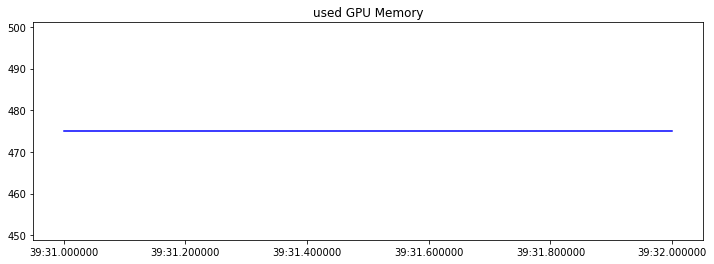

In [17]:
if cfg.track_gpu_mem:
    plot_gpu_usage()

# Load data

### Load train data

* Last week of train set is loaded here, but all data should/can be used
* Labels/correct predictions are created from that same week by slicing off part of session, and then second part of session is used as correct predictions

In [18]:
print(len(train_files))

20


In [19]:
type2id_df = cudf.DataFrame({'type': ['clicks', 'carts', 'orders'], 'type_id': [0,1,2]})
type2id_df.type_id = type2id_df.type_id.astype('int8')

In [20]:
def read_transform_file(f):
    df = cudf.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df = cudf.merge(df, type2id_df, on='type', how='inner').drop('type', axis=1).rename(columns={'type_id': 'type'})
    return df

In [21]:
train = cudf.DataFrame()
for f in train_files:
    train = cudf.concat([train, read_transform_file(f)], ignore_index=True)

train = train.reset_index(drop=True)
print(train.shape)
train.head()

(7683577, 4)


,session,aid,ts,type
0,12093346,623465,1661449342,1
1,12093346,9374,1661449826,0
2,12093346,1673416,1661449602,0
3,12093346,881809,1661450163,0
4,12093346,1777933,1661449350,0


In [22]:
print_date_ts(train['ts'].min())
print_date_ts(train['ts'].max())

Aug 21 2022  22:00:00
Aug 28 2022  21:59:56


### Load train labels

* Train labels consist of (session,aid_list) pairs that did happen in session continuation

In [23]:
train_labels = cudf.read_parquet(train_labels_path)

In [24]:
print(train.shape, train_labels.shape)
train.head()
train_labels.head()

(7683577, 4) (2212692, 3)


,session,type,ground_truth
0,11098528,clicks,[1679529]
1,11098528,carts,[1199737]
2,11098528,orders,"[990658, 950341, 1462506, 1561739, 907564, 369..."
3,11098529,clicks,[1105029]
4,11098530,orders,[409236]


* Change ground_truth from "aid in list" to "one aid per row" -> (session, type) pairs will now be repeated where len(ground_truth) was >=2

In [25]:
train_labels = cudf.merge(train_labels, type2id_df, on='type', how='inner').drop('type', axis=1).rename(columns={'type_id': 'type'})
train_labels = train_labels.explode('ground_truth').rename(columns={'ground_truth': 'aid'})[['session', 'type', 'aid']]
train_labels = train_labels.astype({
    'session': 'int32',
    'aid': 'int32',
    'type': 'int8',
})
print(train_labels.shape)
train_labels.head()

(2650372, 3)


,session,type,aid
0,11126896,1,265905
0,11126896,1,204884
0,11126896,1,240614
0,11126896,1,1121927
0,11126896,1,607372


* Add columns ground_truth - gt that marks all pairs as 1, that is they happened

In [26]:
train_labels['gt'] = 1
train_labels['gt'] = train_labels['gt'].astype('int8')
train_labels.dtypes

session    int32
type        int8
aid        int32
gt          int8
dtype: object

In [27]:
print_gpu_mem_info()

Free - 15577 MiB 	Total - 16280 MiB


# Load candidates

In [28]:
def load_df_from_files(files_list):
    df = cudf.DataFrame()
    for f in files_list:
        df = cudf.concat([df, cudf.read_parquet(f)], ignore_index=True)
    df = df.reset_index(drop=True)
    return df
def preview_df(df):
    print(len_mils(df))
    display(df.head(1))

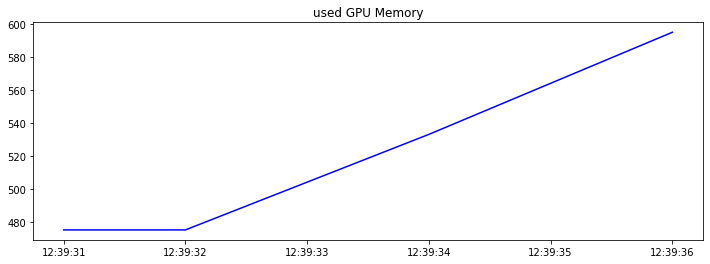

In [29]:
plot_gpu_usage()

# Add feature columns

* Generate new features that will be usefull in predicting if (session,aid) pair happened

In [30]:
def bin_and_scale_feature(df, col, num_bins=1000, new_coltype='int16'):
    df[col] = num_bins * df[col] / df[col].max()
    df[col] = df[col].astype(new_coltype)
    return df

## Item features

### Number of clicks log

In [31]:
def calc_aid_num_log(df):
    dfx = df.groupby('aid').size().reset_index().rename(columns={0: 'aid_num'}).drop_duplicates('aid') 
    
    # Smt like log of percentage
    x_log = cudf.cupy.log(1+dfx['aid_num'])
    x_log = x_log / cudf.cupy.max(x_log)
    dfx['aid_num_log'] = cudf.cupy.asnumpy(x_log)
    dfx['aid_num_log'] = dfx['aid_num_log'].astype('float32')
    del dfx['aid_num']
    
    return dfx

In [32]:
def add_aid_num_log(to_df, calc_from_df):
    tmp_df = calc_aid_num_log(calc_from_df)
    colname = tmp_df.columns[1]
    to_df = cudf.merge(to_df, tmp_df, on='aid', how='left')
    to_df[colname] = to_df[colname].fillna(0)
    return to_df

In [33]:
# Calculate number of repetitions of item in dataframe (in time period), of some event type
def calc_aid_type_num_log(df, event_type):
    type_nums = {'clicks':0, 'carts':1, 'orders':2}
    type_num = type_nums[event_type]
    colname = f'aid_{event_type}_num'
    dfx = df.loc[df.type==type_num].groupby('aid').size().reset_index().rename(columns={0: colname}).drop_duplicates('aid')
    
#     # Just percentage 
#     colname_log = f'{colname}_log'
#     dfx[colname_log] = dfx[colname] / dfx[colname].max()
    
    # Smt like log of percentage
    x_log = cudf.cupy.log(1+dfx[colname])
    x_log = x_log / cudf.cupy.max(x_log)
    colname_log = f'{colname}_log'
    dfx[colname_log] = cudf.cupy.asnumpy(x_log)

    dfx[colname_log] = dfx[colname_log].astype('float32')
    del dfx[colname]
    
    return dfx

In [34]:
def add_aid_type_num_log(to_df, calc_from_df, event_type):
    tmp_df = calc_aid_type_num_log(calc_from_df, event_type)
    colname = tmp_df.columns[1]
    to_df = cudf.merge(to_df, tmp_df, on='aid', how='left')
    to_df[colname] = to_df[colname].fillna(0)
    return to_df

In [35]:
do_test=False
if do_test:
    x = candidates_df.drop_duplicates('aid')
    print(x.shape)
    x = add_aid_type_num_log(x, train, 'orders')
#     x = add_aid_type_num_log(x, train, 'clicks')
    print(x.shape)
    print(x.isna().any())
    display(x.head())
    
    plt.scatter(range(0,len(x)), x[x.columns[-1]].to_pandas())
    plt.show()
    
    del x

### Number of clicks

In [36]:
# Calculate number of repetitions of item in dataframe (in time period), of some event type
def calc_aid_type_num(df, event_type):
    type_nums = {'clicks':0, 'carts':1, 'orders':2}
    type_num = type_nums[event_type]
    colname = f'aid_{event_type}_num'
    return df.loc[df.type==type_num].groupby('aid').size().reset_index().rename(columns={0: colname}).drop_duplicates('aid')

In [37]:
def add_aid_type_num(to_df, calc_from_df, event_type):
    tmp_df = calc_aid_type_num(calc_from_df, event_type)
    colname = tmp_df.columns[1]
    to_df = cudf.merge(to_df, tmp_df, on='aid', how='left')
    to_df[colname] = to_df[colname].fillna(0)
    return to_df

### Number of Item events per session log

In [38]:
# num clicks of item in different sessions
def calc_aid_type_num_ps(df, event_type):
    type_nums = {'clicks':0, 'carts':1, 'orders':2}
    type_num = type_nums[event_type]
    colname = f'aid_{event_type}_num_ps'
    return df.loc[df.type==type_num].groupby('aid').session.nunique().reset_index().rename(columns={'session': colname}).drop_duplicates('aid')

In [39]:
def add_aid_type_num_ps(to_df, calc_from_df, event_type):
    tmp_df = calc_aid_type_num_ps(calc_from_df, event_type)
    colname = tmp_df.columns[1]
    to_df = cudf.merge(to_df, tmp_df, on='aid', how='left')
    to_df[colname] = to_df[colname].fillna(0)
    return to_df

In [40]:
def calc_aid_type_num_ps_log(df, event_type):
    type_nums = {'clicks':0, 'carts':1, 'orders':2}
    type_num = type_nums[event_type]
    
    colname = f'aid_{event_type}_num_ps'
    dfx = df.loc[df.type==type_num].groupby('aid').session.nunique().reset_index().rename(columns={'session': colname}).drop_duplicates('aid')
    
#     # Just percentage 
#     colname_log = f'{colname}_log'
#     dfx[colname_log] = dfx[colname] / dfx[colname].max()
    
    # Smt like log of percentage
    x_log = cudf.cupy.log(1+dfx[colname])
    x_log = x_log / cudf.cupy.max(x_log)
    colname_log = f'{colname}_log'
    dfx[colname_log] = cudf.cupy.asnumpy(x_log)

    dfx[colname_log] = dfx[colname_log].astype('float32')
    del dfx[colname]
    
    return dfx

In [41]:
def add_aid_type_num_ps_log(to_df, calc_from_df, event_type):
    tmp_df = calc_aid_type_num_ps_log(calc_from_df, event_type)
    colname = tmp_df.columns[1]
    to_df = cudf.merge(to_df, tmp_df, on='aid', how='left')
    to_df[colname] = to_df[colname].fillna(0)
    return to_df

In [42]:
do_test=False
if do_test:
    x = train.drop_duplicates('aid')
    print(x.shape)
    x = add_aid_type_num_ps_log(x, train, 'orders')
    print(x.shape)
    print(x.isna().any())
    display(x.head())
    
    plt.scatter(range(0,len(x)), x[x.columns[-1]].to_pandas())
    plt.show()
    
    del x

### Aid num features

In [43]:
def add_aid_all_num_log(calc_from_df, to_df, bin_and_scale=False):
    to_df = add_aid_num_log(calc_from_df=calc_from_df, to_df=to_df)
    to_df = add_aid_type_num_log(calc_from_df=calc_from_df, to_df=to_df, event_type='clicks')
    to_df = add_aid_type_num_log(calc_from_df=calc_from_df, to_df=to_df, event_type='carts')
    to_df = add_aid_type_num_log(calc_from_df=calc_from_df, to_df=to_df, event_type='orders')
    
    to_df = add_aid_type_num_ps_log(calc_from_df=calc_from_df, to_df=to_df, event_type='clicks')
    to_df = add_aid_type_num_ps_log(calc_from_df=calc_from_df, to_df=to_df, event_type='carts')
    to_df = add_aid_type_num_ps_log(calc_from_df=calc_from_df, to_df=to_df, event_type='orders')
    
    aid_all_num_cols = [
        'aid_num_log', 'aid_clicks_num_log', 'aid_carts_num_log', 'aid_orders_num_log', 
        'aid_clicks_num_ps_log', 'aid_carts_num_ps_log', 'aid_orders_num_ps_log'
    ]
    for col in aid_all_num_cols:
        to_df = bin_and_scale_feature(to_df, col, num_bins=1000, new_coltype='int16')    
    
    return to_df

### Number of aid events in day

In [44]:
def get_event_num(event_name):
    if event_name == 'clicks':
        return 0
    elif event_name == 'carts':
        return 1
    else:
        return 2

In [45]:
def add_aids_in_day(candidates_df, from_df, day_num=1, event_names=['clicks', 'carts', 'orders']):
    from_ts = from_df.ts.max() - day_num * 24*60*60
    to_ts = from_df.ts.max() - (day_num-1) * 24*60*60
    tmp = from_df.loc[(from_df.ts>from_ts) & (from_df.ts<=to_ts)]

    # print_date_ts(tmp.ts.min())
    # print_date_ts(tmp.ts.max())

    for event_name in event_names:
        # print(event_name, get_event_num(event_name))
        aids_in_day = tmp.loc[tmp.type==get_event_num(event_name)].groupby('aid').size()
        new_colname = f'{event_name}_in_day_{day_num}'
        aids_in_day = aids_in_day.reset_index()
        aids_in_day.columns = ['aid', new_colname]
        candidates_df = cudf.merge(candidates_df, aids_in_day, on='aid', how='left').fillna(0)
        del aids_in_day

        if event_name == 'clicks':
            candidates_df[new_colname] = candidates_df[new_colname].astype('int16')
        else:
            candidates_df[new_colname] = candidates_df[new_colname].astype('uint8')

    return candidates_df

## Session features

In [46]:
def add_events_in_prev_hours(candidates_df, from_df, num_hours=2, event_names=['clicks', 'carts', 'orders']):
    remove_above_time = 60 * 60 * num_hours
    tmp = cudf.merge(from_df, from_df.groupby('session').ts.max().reset_index().rename(columns={'ts': "session_ts_max"}), on='session')
    tmp['seconds_from_last_event'] = tmp['session_ts_max'] - tmp['ts']

    def colname(ev):
        return f'num_{ev}_last_{num_hours}_hours'

    for event_name in event_names:
        if event_name == 'clicks':
            event_name_num = 0
        elif event_name == 'carts':
            event_name_num = 1
        else:
            event_name_num = 2

        events_in_last_hours = tmp.loc[(tmp.type==event_name_num) & (tmp.seconds_from_last_event < remove_above_time)].groupby('session').size()
        new_colname = colname(event_name)
        events_in_last_hours = events_in_last_hours.reset_index()
        events_in_last_hours.columns = ['session', new_colname]
        candidates_df = cudf.merge(candidates_df, events_in_last_hours, on='session', how='left').fillna(0)
        del events_in_last_hours
        
        candidates_df[new_colname] = candidates_df[new_colname].astype('int16')

#     new_colname = f'cart_order_diff_last_{num_hours}_hours'
#     candidates_df[new_colname] = candidates_df[colname('carts')] - candidates_df[colname('orders')]
#     candidates_df[new_colname] = candidates_df[new_colname].astype('int16')

    return candidates_df

In [47]:
# Session length column
def add_session_length(df, bin_and_scale=False):
    tmp = cudf.merge(df, df.groupby('session').size().reset_index().rename(columns={0: "session_length"}), on='session')
    if bin_and_scale:
        tmp = bin_and_scale_feature(tmp, 'session_length', num_bins=1000, new_coltype='int16')
    return tmp

In [48]:
# Session length column
def add_session_type_mean(to_df, from_df, bin_and_scale=False):
    to_df = cudf.merge(to_df, from_df.groupby('session').type.mean().reset_index().rename(columns={'type': "type_mean"}), on='session')
    if bin_and_scale:
        to_df = bin_and_scale_feature(to_df, 'type_mean', num_bins=200, new_coltype='uint8')
    return to_df

In [49]:
# Session length column
def add_session_ts_info(to_df, from_df):
    max_ts = from_df.ts.max()
    min_ts = from_df.ts.min()
    max_diff_ts = max_ts-min_ts
    
    to_df = cudf.merge(to_df, from_df.groupby('session').ts.max().reset_index().rename(columns={'ts': "ts_max"}), on='session')
    to_df.ts_max = (127 * ((to_df.ts_max - min_ts) / max_diff_ts))
    to_df = cudf.merge(to_df, from_df.groupby('session').ts.min().reset_index().rename(columns={'ts': "ts_min"}), on='session')
    to_df.ts_min = (127 * ((to_df.ts_min - min_ts) / max_diff_ts))
    
    to_df = cudf.merge(to_df, from_df.groupby('session').ts.mean().reset_index().rename(columns={'ts': "ts_mean"}), on='session')
    to_df.ts_mean = (127 * ((to_df.ts_mean - min_ts) / max_diff_ts))
    to_df = cudf.merge(to_df, from_df.groupby('session').ts.median().reset_index().rename(columns={'ts': "ts_med"}), on='session')
    to_df.ts_med = (127 * ((to_df.ts_med - min_ts) / max_diff_ts))
    
    to_df['ts_duration'] = to_df.ts_max - to_df.ts_min
    for col in ['ts_max', 'ts_min', 'ts_duration', 'ts_mean', 'ts_med']:
        to_df[col] = to_df[col].astype('int8')
        
#     Remove these ********** easiest way
    for col in ['ts_max', 'ts_min', 'ts_mean', 'ts_med']:
        del to_df[col]
        
    return to_df

In [50]:
# Session number of clicks,carts,orders
def add_session_num_events(to_df, from_df):
    df2 = cudf.DataFrame({'type': [0], 'type_click': [1]})
    df3 = cudf.DataFrame({'type': [1], 'type_cart': [1]})
    df4 = cudf.DataFrame({'type': [2], 'type_order': [1]})
    tmp = from_df[['session', 'type']]
    tmp = cudf.merge(tmp, df2, on='type', how='left').fillna(0)
    tmp = cudf.merge(tmp, df3, on='type', how='left').fillna(0)
    tmp = cudf.merge(tmp, df4, on='type', how='left').fillna(0)
    
    new_cols = ['session_clicks', 'session_carts', 'session_orders']

    tmp = cudf.merge(tmp, tmp.groupby('session').type_click.sum().reset_index().rename(columns={'type_click': new_cols[0]}), on='session')
    tmp = cudf.merge(tmp, tmp.groupby('session').type_cart.sum().reset_index().rename(columns={'type_cart': new_cols[1]}), on='session')
    tmp = cudf.merge(tmp, tmp.groupby('session').type_order.sum().reset_index().rename(columns={'type_order': new_cols[2]}), on='session')
    del tmp['type_click'] 
    del tmp['type_cart'] 
    del tmp['type_order']
    del tmp['type']
    tmp = tmp.drop_duplicates('session', ignore_index=True)
    
    # Bin and scale:
    
    max_events = tmp[new_cols[0]].max()
    for nc in new_cols:
        m=tmp[nc].max()
        print(m)
        if max_events < m:
            max_events = m
    
    for nc in new_cols:
        tmp[nc] = 1000 * tmp[nc] / max_events
        tmp[nc] = tmp[nc].astype('int16')

    to_df = cudf.merge(to_df, tmp, on='session', how='left').fillna(0)
    
    return to_df

## Session,item interaction features

## Repeated candidates featues

In [58]:
# Smallest ts (further from last date) should get larger num, so need to sort by ts in order to reverse cumcount
# Need to reset_index also because 
# cumcount created column is ordered by index and df index will not be ordered after sorting
def add_action_num_reverse_chrono(df):
    # df = df.sort_values('ts', ascending=False).reset_index(drop=True) # enough to sort by ts
    df = df.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
    df['action_num_reverse_chrono'] = df.groupby('session', sort=False).cumcount()
    return df

# recency multiplied by weight
def add_type_weighted_log_recency_score(df):
    weights_df = cudf.DataFrame({'type': [0,1,2], 'weight': [1,6,3]})
    df['type_weighted_log_recency_score'] = cudf.merge(df[['type']], weights_df, on='type', how='inner')['weight'] * df['log_recency_score']
    df['type_weighted_log_recency_score'] = df['type_weighted_log_recency_score'].astype('float32')
    return df

# recency from 0-1
def add_log_recency_score(df):
    linear_interpolation = 0.1 + ((1-0.1) / (df['session_length']-1)) * (df['session_length']-df['action_num_reverse_chrono']-1)
    df['log_recency_score'] = cudf.Series(2**linear_interpolation - 1).fillna(1)
    df['log_recency_score'] = df['log_recency_score'].astype('float32')
    return df

In [59]:
def add_ses_item_features(df, bin_and_scale=False):
    df = add_action_num_reverse_chrono(df)
    df = add_log_recency_score(df)
    df = add_type_weighted_log_recency_score(df)
    
    repeated_df_features = ['action_num_reverse_chrono', 'log_recency_score', 'type_weighted_log_recency_score']
    for col in repeated_df_features:
        df = bin_and_scale_feature(df, col, num_bins=1000, new_coltype='int16')
        
    return df

# Train

clicks
67,085,202


,session,aid,type,repetitions,clicks_final_wgt,clicks_similarity_wgt
0,11638906,1022080,0,0,22.836227,-1.0


67,085,202
session                      int32
aid                          int32
type                          int8
clicks_final_wgt           float32
clicks_similarity_wgt      float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
clicks_in_day_1              int16
clicks_in_day_2              int16
dtype: object


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,session_length,type_mean,aid_num_log,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,clicks_in_day_1,clicks_in_day_2
0,11098528,876129,-1,7.412702,7.412702,1,0,0,0,2,0,645,646,521,427,676,539,415,165,123
1,11098528,1790438,-1,7.184778,7.184778,1,0,0,0,2,0,627,633,442,346,663,452,351,91,95
2,11098528,1157882,-1,7.478803,7.478803,1,0,0,0,2,0,634,637,482,457,657,487,463,100,90
3,11098528,588923,-1,8.094374,8.094374,1,0,0,0,2,0,613,615,473,427,646,487,415,53,55
4,11098528,11830,0,21.594374,-1.000000,1,0,0,0,2,0,677,681,541,505,712,562,500,107,121


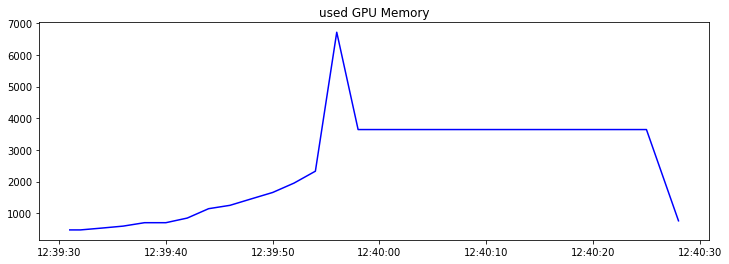

carts
70,950,837


,session,aid,type,repetitions,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt
0,11278654,1441266,1,1,103.335617,-1.0,-1.0


70,950,837
session                      int32
aid                          int32
type                          int8
carts_final_wgt            float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
orders_in_day_1              uint8
carts_in_day_2               uint8
orders_in_day_2              uint8
dtype: object


,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098528,1519088,-1,5.871357,5.871357,0.000000,1,0,0,0,...,625,454,346,662,466,351,8,1,7,1
1,11098528,409620,-1,8.754446,5.988285,5.532322,1,0,0,0,...,708,572,558,743,589,549,23,2,22,4
2,11098528,756588,-1,9.198213,6.251383,5.893659,1,0,0,0,...,755,613,606,803,636,595,35,9,37,1
3,11098528,1586171,-1,9.374246,6.381359,5.985774,1,0,0,0,...,741,572,534,786,590,541,21,0,15,2
4,11098528,1689044,-1,8.966624,6.121901,5.689447,1,0,0,0,...,652,549,524,682,565,521,25,4,23,2


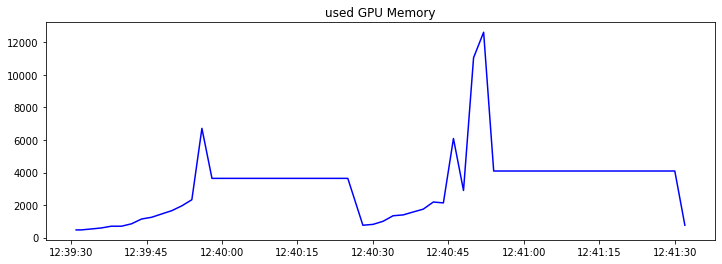

orders
70,358,179


,session,aid,type,repetitions,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt
0,12539536,917587,0,1,27.801207,-1.0,-1.0


70,358,179
session                      int32
aid                          int32
type                          int8
orders_final_wgt           float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
orders_in_day_1              uint8
carts_in_day_2               uint8
orders_in_day_2              uint8
dtype: object


,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098528,307904,-1,12.823963,6.615704,4.138840,1,0,0,0,...,548,396,286,574,399,290,6,0,4,1
1,11098528,1125638,-1,11.749630,6.015499,3.822755,1,0,0,0,...,686,563,573,730,580,573,25,2,17,1
2,11098528,231487,-1,13.303909,6.813148,4.327174,1,0,0,0,...,753,652,648,793,670,631,47,7,21,2
3,11098528,1182614,-1,13.969893,7.021736,4.632104,1,0,0,0,...,725,583,558,765,603,558,25,2,24,4
4,11098528,77440,-1,12.556222,6.580265,3.983972,1,0,0,0,...,672,542,457,712,564,448,7,0,17,1


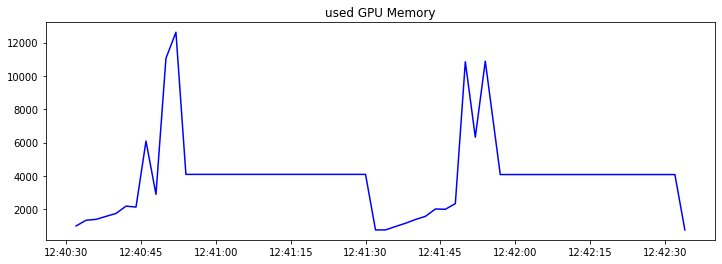

In [61]:
# for event_name in ['clicks']:
for event_name in ['clicks', 'carts', 'orders']:
    print(event_name)

    candidates_df = load_df_from_files(pred_df_files[event_name])
    preview_df(candidates_df)
    

    candidates_df['session'] = candidates_df['session'].astype('int32')
    candidates_df['aid'] = candidates_df['aid'].astype('int32')

    candidates_df['type'] = candidates_df['type'].astype('int8')
    del candidates_df['repetitions']
#     candidates_df['repetitions'] = candidates_df['repetitions'].astype('int16')
    if event_name == 'clicks':
        candidates_df['clicks_final_wgt'] = candidates_df['clicks_final_wgt'].astype('float32')
        candidates_df['clicks_similarity_wgt'] = candidates_df['clicks_similarity_wgt'].astype('float32')
    elif event_name == 'carts':
        candidates_df['carts_final_wgt'] = candidates_df['carts_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')
    elif event_name == 'orders':
        candidates_df['orders_final_wgt'] = candidates_df['orders_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')

    # candidates_df['session_size'] = candidates_df['session_size'].astype('int16')
    # candidates_df.dtypes


    if cfg.add_features['add_events_in_prev_hours']:
        candidates_df = add_events_in_prev_hours(candidates_df, from_df=train)
    if cfg.add_features['add_session_ts_info']:
        candidates_df = add_session_ts_info(to_df=candidates_df, from_df=train)
    if cfg.add_features['add_session_num_events']:
        candidates_df = add_session_num_events(to_df=candidates_df, from_df=train)

    if cfg.add_features['add_session_length']:
        sessions_lengths_df = add_session_length(train[['session']], bin_and_scale=True).drop_duplicates('session')
        candidates_df = cudf.merge(candidates_df, sessions_lengths_df, on='session', how='left')
        del sessions_lengths_df
    if cfg.add_features['add_session_type_mean']:
        candidates_df = add_session_type_mean(candidates_df, train, bin_and_scale=True)

    if cfg.add_features['add_aid_all_num_log']:
        candidates_df = add_aid_all_num_log(calc_from_df=train, to_df=candidates_df, bin_and_scale=True)

    if len(cfg.add_features['add_aids_in_day']) > 0:
        for day_num in cfg.add_features['add_aids_in_day']:
            if event_name == 'clicks':
                candidates_df = add_aids_in_day(candidates_df, train, day_num=day_num, event_names=['clicks'])
            else:
                candidates_df = add_aids_in_day(candidates_df, train, day_num=day_num, event_names=['carts', 'orders'])

    # if cfg.downsample_neg_rep > 0:
    #     candidates_df = downsample_negatives(candidates_df, train_labels, take_negatives_perc=cfg.downsample_neg_rep)

    candidates_df = candidates_df.sort_values('session', ignore_index=True).reset_index(drop=True)

    display_before_save(candidates_df)

    candidates_df.to_pandas().to_parquet(f'./train_candidates_{event_name}_df.pqt')

    del candidates_df
    gc.collect()

    sleep(2)
    plot_gpu_usage()

### Downsample

In [62]:
for event_name in ['clicks', 'carts', 'orders']:
    print(event_name)
    candidates_df = cudf.read_parquet(f'./train_candidates_{event_name}_df.pqt')
    print('Candidates per session', candidates_df.groupby('session').size().mean())

    if cfg.downsample_neg_rep > 0:
        candidates_df = downsample_negatives(candidates_df, train_labels, take_negatives_perc=cfg.downsample_neg_rep)

    candidates_df.to_pandas().to_parquet(f'./train_candidates_{event_name}_df.pqt')
    print('Candidates per session', candidates_df.groupby('session').size().mean())
    

clicks
Candidates per session 37.24367231440815
(67085202, 21)


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,session_length,...,aid_num_log,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,clicks_in_day_1,clicks_in_day_2,gt
0,11098731,310781,-1,3.927071,3.927071,2,0,0,7,6,...,170,174,0,0,189,0,0,1,1,0
1,11098731,1056439,-1,3.927071,3.927071,2,0,0,7,6,...,0,0,0,0,0,0,0,0,0,0


1,287,133 16,449,517
len - 17,736,650


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,session_length,type_mean,aid_num_log,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,clicks_in_day_1,clicks_in_day_2
0,11098810,1657316,0,30.65225,-1.00000,4,0,0,0,8,0,476,474,322,195,479,281,198,35,21
1,11098734,704548,-1,5.13395,5.13395,1,0,0,0,2,0,389,364,301,286,348,318,290,4,7


Candidates per session 9.867843836078288
carts
Candidates per session 39.38975578639512
(70950837, 24)


,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2,gt
0,11098789,691177,0,22.770302,-1.000000,-1.000000,2,0,0,0,...,0,0,232,0,0,0,0,0,0,0
1,11098790,243025,-1,2.403920,1.745715,1.316408,1,0,0,0,...,179,0,336,189,0,3,0,0,0,0


1,285,729 17,416,277
len - 18,702,006


,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098810,1657316,0,37.344849,-1.000000,-1.000000,4,0,0,0,...,474,322,195,479,281,198,1,0,3,0
1,11099173,1106176,-1,2.929130,1.906575,2.045109,1,0,0,0,...,67,77,0,73,81,0,0,0,0,0


Candidates per session 10.394143667227446
orders
Candidates per session 39.060730014861896
(70358179, 24)


,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2,gt
0,11099611,4094,-1,3.865560,3.865560,0.000000,1,0,0,0,...,322,195,579,310,198,6,0,4,0,0
1,11099612,1602679,-1,8.301111,5.441248,1.906575,1,0,0,0,...,309,319,557,318,323,2,0,1,2,0


1,268,965 17,272,304
len - 18,541,269


,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098824,388833,0,143.833923,-1.000000,-1.000000,40,1,0,14,...,421,179,0,427,189,0,0,0,2,0
1,11099061,991162,-1,7.124444,4.793557,1.553925,1,0,0,106,...,343,179,123,336,189,125,1,1,0,0


Candidates per session 10.313499469063567


# Fold

In [63]:
# Save fold here to be consistent across multiple model runs

uniq_sessions = train_labels.session.unique()
print('Uniq sessions', len_mils(uniq_sessions))
folds_arr = []
random_start = 1
for i in range(len(uniq_sessions)):
    folds_arr.append((i+random_start)%5)
    
df_fold = cudf.DataFrame({'session': uniq_sessions, 'fold': folds_arr})
df_fold.fold = df_fold.fold.astype('int8')

df_fold.to_parquet('./df_fold.pqt')
preview_df(df_fold)

Uniq sessions 1,801,251
1,801,251


,session,fold
0,11098528,1


# Val

In [65]:
def get_val_data(valid_fold_num):
    train = cudf.DataFrame()
    for f in train_files:
        train = cudf.concat([train, read_transform_file(f)], ignore_index=True)

    train = train.reset_index(drop=True)
    print(len_mils(train))

    val_data = train.copy()
    val_data = cudf.merge(val_data, df_fold.loc[df_fold.fold==valid_fold_num], on='session')
    print(len_mils(val_data))
    
    del train
    del val_data['fold']    
    
    return val_data

In [66]:
# Load val data

val_data = get_val_data(cfg.val_fold)
preview_df(val_data)

7,683,577
1,539,187
1,539,187


,session,aid,ts,type
0,12096492,377728,1661449664,0


In [ ]:
# Load train data

train = cudf.DataFrame()
for f in train_files:
    train = cudf.concat([train, read_transform_file(f)], ignore_index=True)

train = train.reset_index(drop=True)
preview_df(train)

Event clicks
7,683,577
1,539,187
13,419,550


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt
0,11640147,1008656,-1,4.757915,4.757915


13,419,550
session                      int32
aid                          int32
type                          int8
clicks_final_wgt           float32
clicks_similarity_wgt      float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
clicks_in_day_1              int16
clicks_in_day_2              int16
dtype: object


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,session_length,type_mean,aid_num_log,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,clicks_in_day_1,clicks_in_day_2
0,11098532,738098,-1,8.062702,8.062702,2,0,0,0,4,0,667,680,382,123,707,395,125,209,172
1,11098532,108125,-1,14.259855,14.259855,2,0,0,0,4,0,829,845,574,542,889,595,531,1283,1031
2,11098532,1325760,-1,7.505363,7.505363,2,0,0,0,4,0,568,578,277,195,601,281,198,75,65
3,11098532,435253,-1,7.788868,7.788868,2,0,0,0,4,0,714,729,405,0,768,417,0,473,288
4,11098532,1402537,-1,8.322988,8.322988,2,0,0,0,4,0,661,674,322,319,707,325,250,183,162


len 13,419,550
uniq sessions 360,250

1,348,518 1,346,405 1,342,333 1,343,856 
1,338,385 1,338,837 1,339,706 1,339,941 
1,342,414 1,339,155 
---
all files summed
len 13,419,550
uniq sessions 360,250
Event carts
7,683,577
1,539,187
14,190,772


,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt
0,11819122,993765,-1,20.445921,14.086018,12.719807


14,190,772
session                      int32
aid                          int32
type                          int8
carts_final_wgt            float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
orders_in_day_1              uint8
carts_in_day_2               uint8
orders_in_day_2              uint8
dtype: object


,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098532,776826,-1,8.507115,5.729223,5.555785,2,0,0,0,...,572,286,0,595,292,0,0,0,2,0
1,11098532,522226,-1,8.732311,5.910065,5.644492,2,0,0,0,...,583,179,123,605,189,125,0,0,0,0
2,11098532,839420,-1,8.805915,5.962885,5.686059,2,0,0,0,...,594,294,123,625,292,125,5,0,3,0
3,11098532,470541,-1,8.778299,5.923533,5.709533,2,0,0,0,...,575,301,247,597,258,198,0,0,3,0
4,11098532,612920,-1,12.656202,7.274292,10.763819,2,0,0,0,...,730,440,370,765,444,375,13,1,8,1


len 14,190,772
uniq sessions 360,250

1,422,274 1,421,390 1,420,739 1,420,360 
1,418,101 1,417,791 1,416,827 1,417,038 
1,417,690 1,418,562 
---
all files summed
len 14,190,772
uniq sessions 360,250
Event orders
7,683,577
1,539,187
14,074,439


,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt
0,12539682,1052457,-1,21.830122,21.830122,0.0


14,074,439
session                      int32
aid                          int32
type                          int8
orders_final_wgt           float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
orders_in_day_1              uint8
carts_in_day_2               uint8
orders_in_day_2              uint8
dtype: object


,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,11098532,1120255,-1,6.408084,6.408084,0.000000,2,0,0,0,...,562,216,195,582,228,198,2,1,1,0
1,11098532,511499,-1,6.576094,6.576094,0.000000,2,0,0,0,...,589,199,0,620,210,0,0,0,0,0
2,11098532,1748862,-1,6.398146,6.398146,0.000000,2,0,0,0,...,624,375,247,644,368,250,5,0,2,0
3,11098532,40073,-1,6.493345,6.493345,0.000000,2,0,0,0,...,602,309,195,625,310,125,1,0,5,0
4,11098532,77906,-1,8.589146,5.970573,1.745715,2,0,0,0,...,539,286,0,560,244,0,0,0,1,0


len 14,074,439
uniq sessions 360,250

1,411,381 1,410,228 1,409,371 1,409,115 
1,405,380 1,405,063 1,405,686 1,405,239 
1,406,978 1,405,998 
---
all files summed
len 14,074,439
uniq sessions 360,250
Free - 15377 MiB 	Total - 16280 MiB


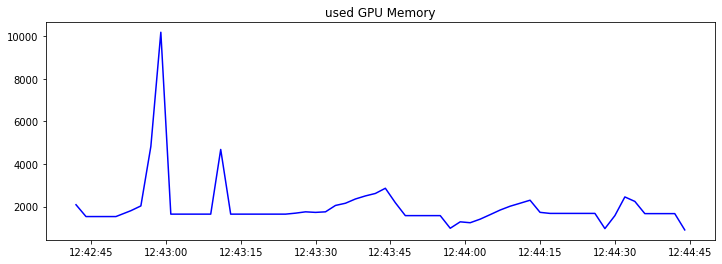

In [68]:
for ev in ['clicks', 'carts', 'orders']:
    print('Event', ev)
    
    val_data = get_val_data(cfg.val_fold)
    
    candidates_df = load_df_from_files(pred_df_files[ev])
    candidates_df = cudf.merge(candidates_df, df_fold.loc[df_fold.fold==cfg.val_fold], on='session')
    del candidates_df['fold']
    
    candidates_df['session'] = candidates_df['session'].astype('int32')
    candidates_df['aid'] = candidates_df['aid'].astype('int32')
    candidates_df['type'] = candidates_df['type'].astype('int8')
    del candidates_df['repetitions']
#     candidates_df['repetitions'] = candidates_df['repetitions'].astype('int16')
#     candidates_df['session_size'] = candidates_df['session_size'].astype('int16')
    if ev=='clicks':
        candidates_df['clicks_final_wgt'] = candidates_df['clicks_final_wgt'].astype('float32')
        candidates_df['clicks_similarity_wgt'] = candidates_df['clicks_similarity_wgt'].astype('float32')
    if ev=='carts':
        candidates_df['carts_final_wgt'] = candidates_df['carts_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')
    if ev=='orders':
        candidates_df['orders_final_wgt'] = candidates_df['orders_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')
    
    preview_df(candidates_df)

    
    if cfg.add_features['add_events_in_prev_hours']:
        candidates_df = add_events_in_prev_hours(candidates_df, from_df=train)
    # ts feautures, num events features
    if cfg.add_features['add_session_ts_info']:
        candidates_df = add_session_ts_info(to_df=candidates_df, from_df=train)
    if cfg.add_features['add_session_num_events']:
        candidates_df = add_session_num_events(to_df=candidates_df, from_df=train)
    
    # session len
    if cfg.add_features['add_session_length']:
        sessions_lengths_df = add_session_length(val_data[['session']], bin_and_scale=True).drop_duplicates('session')
        candidates_df = cudf.merge(candidates_df, sessions_lengths_df, on='session', how='left')
        del sessions_lengths_df
    if cfg.add_features['add_session_type_mean']:
        candidates_df = add_session_type_mean(candidates_df, val_data, bin_and_scale=True)
        
    # Adding num of clicks,carts,orders of items that happened in last train week to candidates
    if cfg.add_features['add_aid_all_num_log']:
        candidates_df = add_aid_all_num_log(calc_from_df=train, to_df=candidates_df, bin_and_scale=True)

    if len(cfg.add_features['add_aids_in_day']) > 0:
        for day_num in cfg.add_features['add_aids_in_day']:
            if ev == 'clicks':
                candidates_df = add_aids_in_day(candidates_df, train, day_num=day_num, event_names=['clicks'])
            else:
                candidates_df = add_aids_in_day(candidates_df, train, day_num=day_num, event_names=['carts', 'orders'])
        
    candidates_df = candidates_df.sort_values('session', ignore_index=True).reset_index(drop=True)
    
    _ = gc.collect()

    display_before_save(candidates_df)
    
#     candidates_df.to_parquet(f'./val_{ev}_candidates_df.pqt')
    split_df_to_files_by_session(candidates_df, chunks=10, filepath=f'./val_{ev}_candidates_df')    
    
    del candidates_df
    _ = gc.collect()
    
time.sleep(2)
print_gpu_mem_info()
plot_gpu_usage()

# Test

In [71]:
# Load test set

print('Test files', len(test_files))
test = cudf.DataFrame()
for f in test_files:
    test = cudf.concat([test, read_transform_file(f)], ignore_index=True)
preview_df(test)

Test files 17
6,928,123


,session,aid,ts,type
0,13105615,1710529,1661796849,0


In [72]:
test.session = test.session.astype('int32')
test.aid = test.aid.astype('int32')

print_date_ts(test.ts.min())
print_date_ts(test.ts.max())

Aug 28 2022  22:00:00
Sep 04 2022  21:59:51


### Generate candidates with features

In [73]:
for ev in ['clicks', 'carts', 'orders']:
    print(len(test_pred_df_files[ev]), 'files')
    
    if len(test_pred_df_files[ev]) == 0:
        assert False, f'Zero test {ev} files' 

10 files
10 files
10 files


In [74]:
for ev in ['clicks', 'carts', 'orders']:
    print(len(test_pred_df_files[ev]), 'files')
    
    candidates_df = cudf.DataFrame()
    for f in test_pred_df_files[ev]:
        candidates_df = cudf.concat([candidates_df, cudf.read_parquet(f)], ignore_index=True)
    candidates_df = candidates_df.reset_index(drop=True)
    
    candidates_df['session'] = candidates_df['session'].astype('int32')
    candidates_df['aid'] = candidates_df['aid'].astype('int32')
    candidates_df['type'] = candidates_df['type'].astype('int8')
    
    del candidates_df['repetitions']
#     candidates_df['repetitions'] = candidates_df['repetitions'].astype('int16')

#     candidates_df['session_size'] = candidates_df['session_size'].astype('int16')
    if ev=='clicks':
        candidates_df['clicks_final_wgt'] = candidates_df['clicks_final_wgt'].astype('float32')
        candidates_df['clicks_similarity_wgt'] = candidates_df['clicks_similarity_wgt'].astype('float32')
    if ev=='carts':
        candidates_df['carts_final_wgt'] = candidates_df['carts_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')
    if ev=='orders':
        candidates_df['orders_final_wgt'] = candidates_df['orders_final_wgt'].astype('float32')
        candidates_df['top_buys_wgt'] = candidates_df['top_buys_wgt'].astype('float32')
        candidates_df['top_buy2buy_wgt'] = candidates_df['top_buy2buy_wgt'].astype('float32')


    # Generated:
    
    if cfg.add_features['add_events_in_prev_hours']:
        candidates_df = add_events_in_prev_hours(candidates_df, from_df=test)
    if cfg.add_features['add_session_ts_info']:
        candidates_df = add_session_ts_info(to_df=candidates_df, from_df=test)
    if cfg.add_features['add_session_num_events']:
        candidates_df = add_session_num_events(to_df=candidates_df, from_df=test)
    
    if cfg.add_features['add_session_length']:
        sessions_lengths_df = add_session_length(test[['session']], bin_and_scale=True).drop_duplicates('session')
        candidates_df = cudf.merge(candidates_df, sessions_lengths_df, on='session', how='left')
        del sessions_lengths_df
    if cfg.add_features['add_session_type_mean']:
        candidates_df = add_session_type_mean(candidates_df, test, bin_and_scale=True)

    if cfg.add_features['add_aid_all_num_log']:
        candidates_df = add_aid_all_num_log(calc_from_df=test, to_df=candidates_df, bin_and_scale=True)

    if len(cfg.add_features['add_aids_in_day']) > 0:
        for day_num in cfg.add_features['add_aids_in_day']:
            if ev == 'clicks':
                candidates_df = add_aids_in_day(candidates_df, test, day_num=day_num, event_names=['clicks'])
            else:
                candidates_df = add_aids_in_day(candidates_df, test, day_num=day_num, event_names=['carts', 'orders'])

        
    candidates_df = candidates_df.sort_values('session', ignore_index=True).reset_index(drop=True)
    
    print(len_mils(candidates_df))
    print(len(candidates_df.columns))
    print('Uniq sessions', candidates_df.session.nunique())
    
    gc.collect()
    print_gpu_mem_info()

    display_before_save(candidates_df)
    split_df_to_files_by_session(candidates_df, chunks=10, filepath=f'./test_{ev}_candidates_df')
    
    del candidates_df
    gc.collect()
    

10 files
62,791,052
20
Uniq sessions 1671803
Free - 12531 MiB 	Total - 16280 MiB
62,791,052
session                      int32
aid                          int32
type                          int8
clicks_final_wgt           float32
clicks_similarity_wgt      float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
clicks_in_day_1              int16
clicks_in_day_2              int16
dtype: object


,session,aid,type,clicks_final_wgt,clicks_similarity_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,session_length,type_mean,aid_num_log,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,clicks_in_day_1,clicks_in_day_2
0,12899779,339846,-1,1.581833,1.581833,1,0,0,0,2,0,535,540,91,0,531,96,0,20,18
1,12899779,1138236,-1,1.581833,1.581833,1,0,0,0,2,0,657,660,289,254,660,288,260,67,60
2,12899779,3295,-1,1.509283,1.509283,1,0,0,0,2,0,317,320,0,0,266,0,0,6,1
3,12899779,1667087,-1,1.581833,1.581833,1,0,0,0,2,0,529,534,0,0,521,0,0,24,17
4,12899779,737445,-1,1.901715,1.901715,1,0,0,0,2,0,393,393,91,0,377,96,0,9,3


len 62,791,052
uniq sessions 1,671,803

6,296,321 6,283,125 6,274,820 6,275,963 
6,276,348 6,276,086 6,273,862 6,280,365 
6,280,196 6,273,966 
---
all files summed
len 62,791,052
uniq sessions 1,671,803
10 files
66,302,616
23
Uniq sessions 1671803
Free - 12105 MiB 	Total - 16280 MiB
66,302,616
session                      int32
aid                          int32
type                          int8
carts_final_wgt            float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
order

,session,aid,type,carts_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,12899779,564302,-1,0.100430,0.000000,1.004302,1,0,0,0,...,603,315,160,615,269,164,3,0,4,1
1,12899779,707616,-1,1.004302,1.004302,0.000000,1,0,0,0,...,356,91,0,341,96,0,0,0,1,0
2,12899779,696438,-1,1.004302,1.004302,0.000000,1,0,0,0,...,121,91,0,127,96,0,0,0,1,0
3,12899779,686765,-1,1.004302,1.004302,0.000000,1,0,0,0,...,567,364,415,554,318,381,0,0,0,0
4,12899779,45290,-1,1.004302,1.004302,0.000000,1,0,0,0,...,121,0,0,127,0,0,0,0,0,0


len 66,302,616
uniq sessions 1,671,803

6,632,332 6,634,549 6,630,160 6,630,858 
6,629,932 6,629,118 6,628,670 6,629,456 
6,628,924 6,628,617 
---
all files summed
len 66,302,616
uniq sessions 1,671,803
10 files
65,922,226
23
Uniq sessions 1671803
Free - 12137 MiB 	Total - 16280 MiB
65,922,226
session                      int32
aid                          int32
type                          int8
orders_final_wgt           float32
top_buys_wgt               float32
top_buy2buy_wgt            float32
num_clicks_last_2_hours      int16
num_carts_last_2_hours       int16
num_orders_last_2_hours      int16
ts_duration                   int8
session_length               int16
type_mean                    uint8
aid_num_log                  int16
aid_clicks_num_log           int16
aid_carts_num_log            int16
aid_orders_num_log           int16
aid_clicks_num_ps_log        int16
aid_carts_num_ps_log         int16
aid_orders_num_ps_log        int16
carts_in_day_1               uint8
order

,session,aid,type,orders_final_wgt,top_buys_wgt,top_buy2buy_wgt,num_clicks_last_2_hours,num_carts_last_2_hours,num_orders_last_2_hours,ts_duration,...,aid_clicks_num_log,aid_carts_num_log,aid_orders_num_log,aid_clicks_num_ps_log,aid_carts_num_ps_log,aid_orders_num_ps_log,carts_in_day_1,orders_in_day_1,carts_in_day_2,orders_in_day_2
0,12899779,707616,-1,1.004302,1.004302,0.0,1,0,0,0,...,356,91,0,341,96,0,0,0,1,0
1,12899779,811662,-1,1.004302,1.004302,0.0,1,0,0,0,...,490,91,0,482,96,0,0,0,0,0
2,12899779,830629,-1,1.004302,1.004302,0.0,1,0,0,0,...,275,0,0,254,0,0,0,0,0,0
3,12899779,894169,-1,1.004302,1.004302,0.0,1,0,0,0,...,243,0,0,186,0,0,0,0,0,0
4,12899779,273918,-1,1.004302,1.004302,0.0,1,0,0,0,...,653,428,508,641,440,520,1,0,1,0


len 65,922,226
uniq sessions 1,671,803

6,597,317 6,592,380 6,591,164 6,587,430 
6,589,705 6,591,773 6,590,183 6,594,123 
6,592,203 6,595,948 
---
all files summed
len 65,922,226
uniq sessions 1,671,803


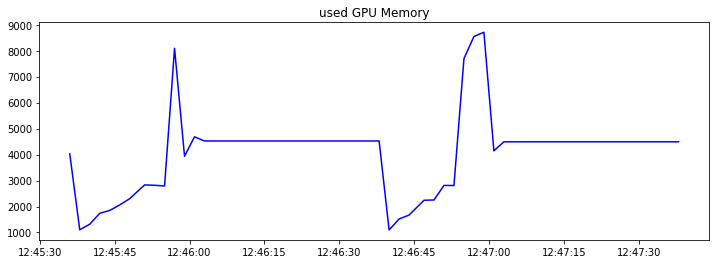

In [75]:
plot_gpu_usage()